### Restaurant Cycle and Business Cycle

July 12, 2017

Brian Dew

Originally posted on the CEPR blog, [here](http://cepr.net/blogs/cepr-blog/the-business-cycle-and-the-restaurant-cycle)

In [2]:
import requests
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import config

%matplotlib inline
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.grid_objs import Column, Grid

import config   ## File with API keys (just to prevent my API keys from being public)
plotly.tools.set_credentials_file(username='bdew', api_key=config.plotly_key)

In [3]:
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}
series_dict = {
#    'TOT_NFP': 'CES0000000001',
#    'FSD_NFP': 'CES7072200001',
#    'AFS_NFP': 'CES7072000001',
#    'MFN_NFP': 'CES3000000001',
#    'FSD_AHE': 'CES7072200008',
#    'AFS_AHE': 'CES7072000008',
#    'TOT_AHE': 'CES0500000008',
#    'MFN_AHE': 'CES3000000008',
    'AFS_QU': 'JTS72000000QUR',
    'TOT_QU': 'JTS00000000QUR',
#    'FSD_HRS': 'CES7072200002',
#    'MFN_HRS': 'CES3000000002',
#    'TOT_HRS': 'CES0500000002',
}
inv_map = {v: k for k, v in series_dict.iteritems()}
series_list = series_dict.values()  # Take just the series codes as a list

date_list = [("1999", "2008"), ("2009", "2017")] #("1980", "1988"),("1989", "1998"), 
df = pd.DataFrame()

In [ ]:
for start, end in date_list:
    data = json.dumps({"seriesid":series_list, "startyear":start, "endyear":end})
    json_data = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    # Store the relevant information in a dictionay and combine into a pandas dataframe
    d = {}
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        d[seriesId] = pd.DataFrame(series['data'])
        if len(series['data']) > 0:
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[seriesId]['date'] = pd.to_datetime(d[seriesId]['period'] + ' ' + d[seriesId]['year'])
            # Keep only date and series values
            d[seriesId] = d[seriesId].sort_values(by='date')[['date', 'value']].set_index('date')
            # Rename and round
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId]).astype(float)
        else:
            d[seriesId]['date'] = pd.Series()
            d[seriesId]['value'] = pd.Series()
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId])
    df = df.append(pd.concat([d[series_list[x]] for x in range(len(d))], axis=1))

In [5]:
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.4.HistorySeasAE'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.1.CurrentSeasAE'
series = 'EES60580001'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df3 = df1.append(df2).reset_index()
# Clean up the date to convert it to pandas datetime
df3.loc[:,'month'] = df3['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df3.loc[:,'day'] = 1
df3.loc[:,'date'] = pd.to_datetime(df3[['year', 'month', 'day']])
df3 = df3.set_index(['date'])['value']
df3 = df3.rename(series)


#df_full = pd.read_csv('Restaurant_Jobs.csv').set_index('date')
df.loc['1980-01-01':'1989-12-01','FSD_NFP'] = df3.loc['1980-01-01':'1989-12-01']
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.56.TradeAHEHist'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.24.TradeAHECurr'
series = 'EEU60580006'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df3 = df1.append(df2).reset_index()
df3 = df3[~df3['period'].isin(['M13'])]
# Clean up the date to convert it to pandas datetime
df3.loc[:,'month'] = df3['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df3.loc[:,'day'] = '01'
df3.loc[:,'date'] = pd.to_datetime(df3[['year', 'month', 'day']])
df3 = df3.set_index(['date'])['value']
df3 = df3.rename(series)

df.loc['1980-01-01':'1989-12-01','FSD_AHE'] = df3.loc['1980-01-01':'1989-12-01']

In [6]:
df['OTH_NFP'] = df['TOT_NFP'] - df['FSD_NFP']
for series in ['AFS_NFP', 'FSD_NFP', 'TOT_NFP', 'OTH_NFP', 'MFN_NFP']:
    df[series+'_12ch'] = df[series].diff(12)
    df[series+'_ch'] = df[series].diff()
    df[series+'_12_pct_ch'] = df[series].pct_change(12).multiply(100)
    # Indexed to end of Great Recession
    df[series+'_index'] = df[series] / df.loc['2009-06-01'][series] * 100
    df[series+'_index1'] = df[series] / df.loc['1980-01-01'][series] * 100
for series in ['AFS_AHE', 'FSD_AHE', 'TOT_AHE']:
    df[series+'_12_pct_ch'] = df[series].pct_change(12).multiply(100)    

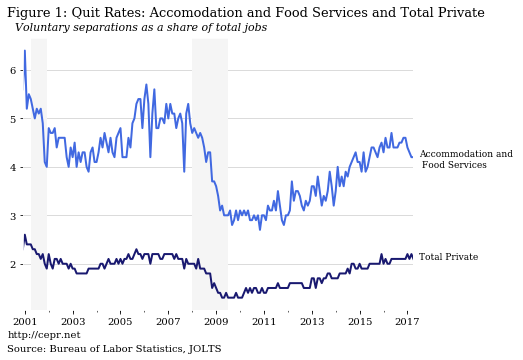

In [7]:
slist4 = ['AFS_QU', 'TOT_QU']

matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist4].dropna().plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 4.0, 'Accommodation and \n Food Services', size=9)
plt.text(570, 2.1, 'Total Private', size=9)
#plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Figure 1: Quit Rates: Accomodation and Food Services and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Voluntary separations as a share of total jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('http://cepr.net', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.annotate('Source: Bureau of Labor Statistics, JOLTS', xy=(-0.04, -0.15), xycoords='axes fraction')
plt.savefig('quit_rates.png', bbox_inches='tight')

### Calculations

In [7]:
df['fsd_share'] = df['FSD_NFP'] / df['TOT_NFP'] * 100
lm_range = [('1982-01-01', '1985-12-01'),('1986-01-01', '1990-12-01'),
            ('1991-01-01', '1995-12-01'),('1996-01-01', '2000-12-01'),
            ('2001-01-01', '2004-12-01'),('2005-01-01', '2007-12-01'),
            ('2008-01-01', '2013-01-01'),('2014-01-01', '2017-05-01')]
d = {}
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date2, 'fsd_share'] - df.loc[date1, 'fsd_share'] 
share = pd.DataFrame(d, index=['Change in restaurant share of total payrolls']).T
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date1:date2, 'TOT_AHE_12_pct_ch'].mean() 
tot_wages = pd.DataFrame(d, index=['Annual wage growth: all sectors']).T
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date1:date2, 'FSD_AHE_12_pct_ch'].mean() 
fsd_wages = pd.DataFrame(d, index=['Annual wage growth: restaurants']).T
table1 = share.join([tot_wages, fsd_wages]) 
table1['Annual wage growth difference'] = table1['Annual wage growth: restaurants'] - table1['Annual wage growth: all sectors']

table1

,Change in restaurant share of total payrolls,Annual wage growth: all sectors,Annual wage growth: restaurants,Annual wage growth difference
1982-1985,0.585768,4.115056,2.366769,-1.748287
1986-1990,0.130953,3.146977,4.467292,1.320315
1991-1995,0.345141,2.691857,2.382533,-0.309324
1996-2000,-0.077885,3.766153,4.414033,0.647880
2001-2004,0.520231,2.863780,2.257528,-0.606252
2005-2007,0.212121,3.538133,4.131219,0.593086
2008-2013,0.546004,2.519497,2.755160,0.235663
2014-2017,0.330641,2.311761,3.703316,1.391555


In [ ]:
d = {}
for date in ['1990-01-01', '2000-01-01', '2010-01-01', '2017-05-01']:
    year = date[:4]
    d[year] = df.loc[date]['FSD_NFP'] / df.loc[date]['TOT_NFP'] * 100
share = pd.DataFrame(d, index=[0]).T

In [ ]:
df.to_csv('Restaurant_Jobs.csv')

In [8]:
df

,TOT_HRS,TOT_NFP,TOT_AHE,MFN_HRS,FSD_HRS,MFN_NFP,FSD_NFP,AFS_NFP,AFS_AHE,MFN_AHE,...,OTH_NFP_index1,MFN_NFP_12ch,MFN_NFP_ch,MFN_NFP_12_pct_ch,MFN_NFP_index,MFN_NFP_index1,AFS_AHE_12_pct_ch,FSD_AHE_12_pct_ch,TOT_AHE_12_pct_ch,fsd_share
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,90802.0,6.57,NaN,NaN,19282.0,4604.0,NaN,NaN,6.82,...,100.000000,NaN,NaN,NaN,164.438001,100.000000,NaN,NaN,NaN,5.070373
1980-02-01,NaN,90882.0,6.63,NaN,NaN,19219.0,4620.0,NaN,NaN,6.88,...,100.074248,NaN,-63.0,NaN,163.900733,99.673270,NaN,NaN,NaN,5.083515
1980-03-01,NaN,90994.0,6.70,NaN,NaN,19217.0,4634.0,NaN,NaN,6.95,...,100.187939,NaN,-2.0,NaN,163.883677,99.662898,NaN,NaN,NaN,5.092643
1980-04-01,NaN,90850.0,6.72,NaN,NaN,18973.0,4604.0,NaN,NaN,6.97,...,100.055686,NaN,-244.0,NaN,161.802831,98.397469,NaN,NaN,NaN,5.067694
1980-05-01,NaN,90419.0,6.76,NaN,NaN,18726.0,4607.0,NaN,NaN,7.02,...,99.552194,NaN,-247.0,NaN,159.696401,97.116482,NaN,NaN,NaN,5.095168
1980-06-01,NaN,90099.0,6.82,NaN,NaN,18490.0,4605.0,NaN,NaN,7.10,...,99.183276,NaN,-236.0,NaN,157.683780,95.892542,NaN,NaN,NaN,5.111045
1980-07-01,NaN,89837.0,6.86,NaN,NaN,18276.0,4606.0,NaN,NaN,7.16,...,98.878164,NaN,-214.0,NaN,155.858775,94.782699,NaN,NaN,NaN,5.127063
1980-08-01,NaN,90097.0,6.91,NaN,NaN,18414.0,4623.0,NaN,NaN,7.24,...,99.160073,NaN,138.0,NaN,157.035647,95.498392,NaN,NaN,NaN,5.131136
1980-09-01,NaN,90210.0,6.95,NaN,NaN,18445.0,4632.0,NaN,NaN,7.30,...,99.280726,NaN,31.0,NaN,157.300017,95.659164,NaN,NaN,NaN,5.134686


In [87]:
# Select relevant columns to plot and rename them
slist = ['FSD_NFP_index1', 'MFN_NFP_index1', 'TOT_NFP_index1']

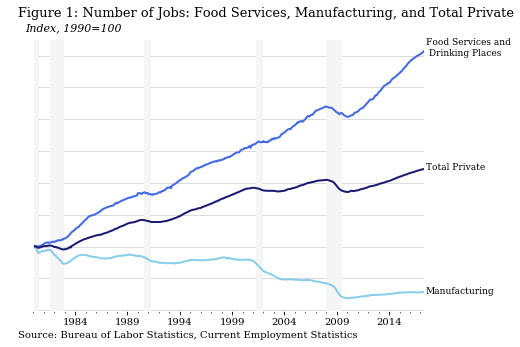

In [88]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'skyblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 250, 'Food Services and \n Drinking Places', size=9)
plt.text(570, 160, 'Total Private', size=9)
plt.text(570, 63, 'Manufacturing', size=9)
plt.annotate('Figure 1: Number of Jobs: Food Services, Manufacturing, and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Index, 1980=100', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('jobs_index.png', bbox_inches='tight')

In [73]:
slist2 = ['FSD_NFP_12_pct_ch', 'OTH_NFP_12_pct_ch']

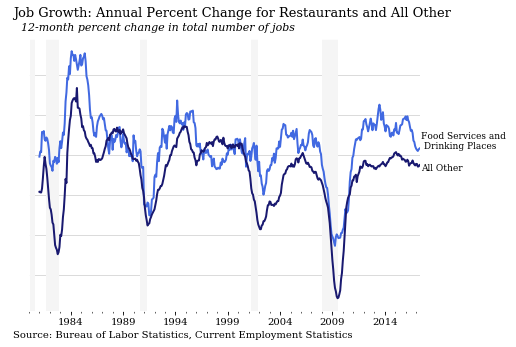

In [74]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist2].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 2.3, 'Food Services and \n Drinking Places', size=9)
plt.text(570, 1.2, 'All Other', size=9)
#plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Job Growth: Annual Percent Change for Restaurants and All Other', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('12-month percent change in total number of jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('jobs_growth_rate.png', bbox_inches='tight')

In [75]:
slist3 = ['FSD_AHE_12_pct_ch', 'TOT_AHE_12_pct_ch']

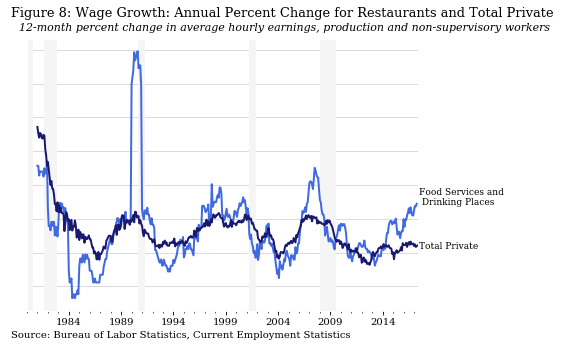

In [76]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist3].plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 4.8, 'Food Services and \n Drinking Places', size=9)
plt.text(570, 2.2, 'Total Private', size=9)
#plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Figure 8: Wage Growth: Annual Percent Change for Restaurants and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('12-month percent change in average hourly earnings, production and non-supervisory workers', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('wage_growth.png', bbox_inches='tight')

In [77]:
slist4 = ['AFS_QU', 'TOT_QU']

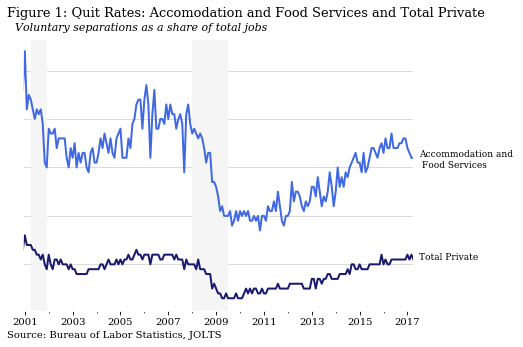

In [78]:
matplotlib.rc('axes',edgecolor='white')
plt.rc('axes', axisbelow=True)
plt.rcParams['font.family'] = 'serif'

df[slist4].dropna().plot(figsize=(7, 5), legend=None, lw=2, color=['royalblue', 'midnightblue'])

plt.grid(axis='y', color='lightgray')

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')

plt.xlabel('')
plt.text(570, 4.0, 'Accommodation and \n Food Services', size=9)
plt.text(570, 2.1, 'Total Private', size=9)
#plt.text(570, 68, 'Manufacturing', size=9)
plt.annotate('Figure 1: Quit Rates: Accomodation and Food Services and Total Private', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Voluntary separations as a share of total jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, JOLTS', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('quit_rates.png', bbox_inches='tight')

### Calculations

In [89]:
df['fsd_share'] = df['FSD_NFP'] / df['TOT_NFP'] * 100
lm_range = [('1982-01-01', '1985-12-01'),('1986-01-01', '1990-12-01'),
            ('1991-01-01', '1995-12-01'),('1996-01-01', '2000-12-01'),
            ('2001-01-01', '2004-12-01'),('2005-01-01', '2007-12-01'),
            ('2008-01-01', '2013-01-01'),('2014-01-01', '2017-05-01')]
d = {}
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date2, 'fsd_share'] - df.loc[date1, 'fsd_share'] 
share = pd.DataFrame(d, index=['Change in restaurant share of total payrolls']).T
table1 = share.join([tot_wages, fsd_wages]) 
d = {}
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date1:date2, 'TOT_AHE_12_pct_ch'].mean() 
tot_wages = pd.DataFrame(d, index=['Annual wage growth: all sectors']).T
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date1:date2, 'FSD_AHE_12_pct_ch'].mean() 
fsd_wages = pd.DataFrame(d, index=['Annual wage growth: restaurants']).T

table1['Annual wage growth difference'] = table1['Annual wage growth: restaurants'] - table1['Annual wage growth: all sectors']

table1

In [79]:
d = {}
for date in ['1990-01-01', '2000-01-01', '2010-01-01', '2017-05-01']:
    year = date[:4]
    d[year] = df.loc[date]['FSD_NFP'] / df.loc[date]['TOT_NFP'] * 100
share = pd.DataFrame(d, index=[0]).T

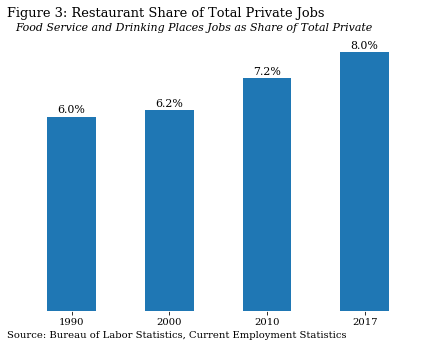

In [80]:
plt.rcParams['ytick.color'] = 'white'
share.plot(figsize=(7, 5), kind='bar', legend=None)
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(share[0]):
    plt.annotate('{}%'.format(round(txt,1)), (i,txt+0.1), ha='center', size=11)
plt.annotate('Figure 3: Restaurant Share of Total Private Jobs', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Food Service and Drinking Places Jobs as Share of Total Private', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('rest_share_total.png', bbox_inches='tight')

In [81]:
date_ranges = [('1990-02-01', '1999-12-01'),('2000-01-01', '2007-12-01'),('2008-01-01', '2017-05-01')]
d = {}
for start, end in date_ranges:
    d_range = '{}-{}'.format(start[:4], end[:4])
    d[d_range] = df['FSD_NFP'].diff().dropna().loc[start:end].values.sum() / df['TOT_NFP'].diff().dropna().loc[start:end].values.sum() * 100
g_share = pd.DataFrame(d, index=[0]).T

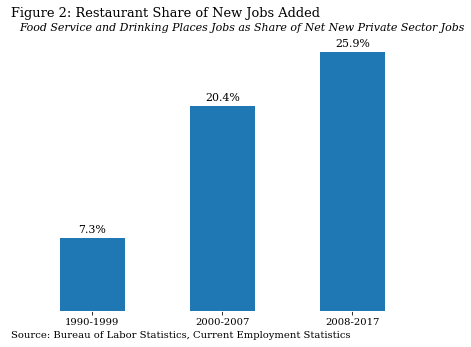

In [82]:
plt.rcParams['ytick.color'] = 'white'
g_share.plot(figsize=(7, 5), kind='bar', legend=None)
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(g_share[0]):
    plt.annotate('{}%'.format(round(txt,1)), (i,txt+0.5), ha='center', size=11)
plt.annotate('Figure 2: Restaurant Share of New Jobs Added', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Food Service and Drinking Places Jobs as Share of Net New Private Sector Jobs', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.1), xycoords='axes fraction')
plt.savefig('rest_share_new.png', bbox_inches='tight')

In [83]:
slist5 = ['FSD_AHE', 'TOT_AHE', 'MFN_AHE']
slist6 = ['FSD_HRS', 'TOT_HRS', 'MFN_HRS']

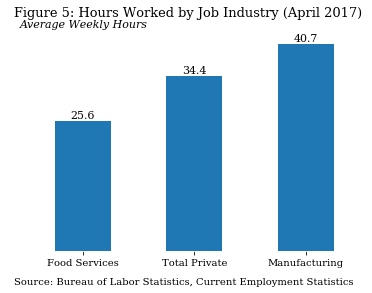

In [84]:
hrs = df[slist6].loc['2017-04-01']
hrs.index = ['Food Services', 'Total Private', 'Manufacturing']
hrs.plot(kind='bar')
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(hrs):
    plt.annotate('{}'.format(round(txt,1)), (i,txt+0.5), ha='center', size=11)
plt.annotate('Figure 5: Hours Worked by Job Industry (April 2017)', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Average Weekly Hours', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.15), xycoords='axes fraction')
plt.savefig('hours_by_job.png', bbox_inches='tight')

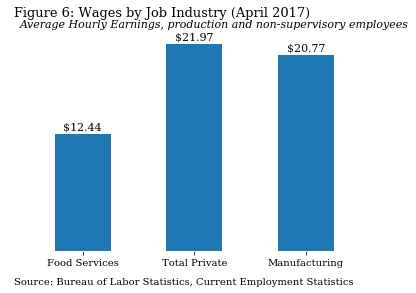

In [85]:
hrs = df[slist5].loc['2017-04-01']
hrs.index = ['Food Services', 'Total Private', 'Manufacturing']
hrs.plot(kind='bar')
plt.xticks(rotation=0)
plt.yticks(color='white')
#plt.grid(axis='y', color='lightgray')
for i, txt in enumerate(hrs):
    plt.annotate('${}'.format(round(txt,2)), (i,txt+0.5), ha='center', size=11)
plt.annotate('Figure 6: Wages by Job Industry (April 2017)', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)
plt.annotate('Average Hourly Earnings, production and non-supervisory employees', xy=(-0.02, 1.03), xycoords='axes fraction', size=11, style='italic')
plt.annotate('Source: Bureau of Labor Statistics, Current Employment Statistics', xy=(-0.04, -0.15), xycoords='axes fraction')
plt.savefig('earnings_by_job.png', bbox_inches='tight')

In [9]:
df['fsd_share'] = df['FSD_NFP'] / df['TOT_NFP'] * 100

In [107]:
d = {}
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date2, 'fsd_share'] - df.loc[date1, 'fsd_share'] 
share = pd.DataFrame(d, index=['Change in restaurant share of total payrolls']).T

In [109]:
table1 = share.join([tot_wages, fsd_wages]) 

In [108]:
d = {}
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date1:date2, 'TOT_AHE_12_pct_ch'].mean() 
tot_wages = pd.DataFrame(d, index=['Annual wage growth: all sectors']).T
for date1, date2 in lm_range:
    year = '{}-{}'.format(date1[:4], date2[:4])
    d[year] = df.loc[date1:date2, 'FSD_AHE_12_pct_ch'].mean() 
fsd_wages = pd.DataFrame(d, index=['Annual wage growth: restaurants']).T
#df['FSD_AHE_12_pct_ch']

In [111]:
table1['Annual wage growth difference'] = table1['Annual wage growth: restaurants'] - table1['Annual wage growth: all sectors']

In [112]:
table1

,Change in restaurant share of total payrolls,Annual wage growth: all sectors,Annual wage growth: restaurants,Annual wage growth difference
1982-1985,0.585768,4.115056,2.366769,-1.748287
1986-1990,0.130953,3.146977,4.467292,1.320315
1991-1995,0.345141,2.691857,2.382533,-0.309324
1996-2000,-0.077885,3.766153,4.414033,0.647880
2001-2004,0.520231,2.863780,2.257528,-0.606252
2005-2007,0.212121,3.538133,4.131219,0.593086
2008-2013,0.546004,2.519497,2.755160,0.235663
2014-2017,0.331499,2.314033,3.678359,1.364326


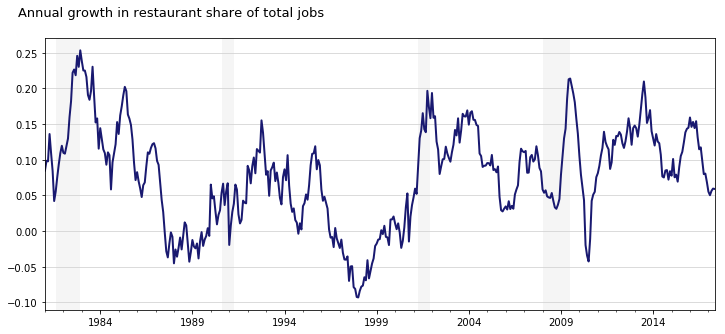

In [9]:
df.loc['1980-01-01':'2017-05-01','fsd_share'].diff(12).dropna().plot(figsize=(12, 5), legend=None, lw=2, color='midnightblue')
plt.grid(axis='y', color='lightgray')
plt.xlabel('')
# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, linewidth=0, color='whitesmoke')
    
plt.annotate('Annual growth in restaurant share of total jobs', xy=(-0.04, 1.08), xycoords='axes fraction',size=13)

plt.savefig('restaurant_share_growth.png', bbox_inches='tight')

In [10]:
df

,TOT_HRS,TOT_NFP,TOT_AHE,MFN_HRS,FSD_HRS,MFN_NFP,FSD_NFP,AFS_NFP,AFS_AHE,MFN_AHE,...,OTH_NFP_index1,MFN_NFP_12ch,MFN_NFP_ch,MFN_NFP_12_pct_ch,MFN_NFP_index,MFN_NFP_index1,AFS_AHE_12_pct_ch,FSD_AHE_12_pct_ch,TOT_AHE_12_pct_ch,fsd_share
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,90802.0,6.57,NaN,NaN,19282.0,4604.0,NaN,NaN,6.82,...,100.000000,NaN,NaN,NaN,164.438001,100.000000,NaN,NaN,NaN,5.070373
1980-02-01,NaN,90882.0,6.63,NaN,NaN,19219.0,4620.0,NaN,NaN,6.88,...,100.074248,NaN,-63.0,NaN,163.900733,99.673270,NaN,NaN,NaN,5.083515
1980-03-01,NaN,90994.0,6.70,NaN,NaN,19217.0,4634.0,NaN,NaN,6.95,...,100.187939,NaN,-2.0,NaN,163.883677,99.662898,NaN,NaN,NaN,5.092643
1980-04-01,NaN,90850.0,6.72,NaN,NaN,18973.0,4604.0,NaN,NaN,6.97,...,100.055686,NaN,-244.0,NaN,161.802831,98.397469,NaN,NaN,NaN,5.067694
1980-05-01,NaN,90419.0,6.76,NaN,NaN,18726.0,4607.0,NaN,NaN,7.02,...,99.552194,NaN,-247.0,NaN,159.696401,97.116482,NaN,NaN,NaN,5.095168
1980-06-01,NaN,90099.0,6.82,NaN,NaN,18490.0,4605.0,NaN,NaN,7.10,...,99.183276,NaN,-236.0,NaN,157.683780,95.892542,NaN,NaN,NaN,5.111045
1980-07-01,NaN,89837.0,6.86,NaN,NaN,18276.0,4606.0,NaN,NaN,7.16,...,98.878164,NaN,-214.0,NaN,155.858775,94.782699,NaN,NaN,NaN,5.127063
1980-08-01,NaN,90097.0,6.91,NaN,NaN,18414.0,4623.0,NaN,NaN,7.24,...,99.160073,NaN,138.0,NaN,157.035647,95.498392,NaN,NaN,NaN,5.131136
1980-09-01,NaN,90210.0,6.95,NaN,NaN,18445.0,4632.0,NaN,NaN,7.30,...,99.280726,NaN,31.0,NaN,157.300017,95.659164,NaN,NaN,NaN,5.134686


In [25]:
df.loc['1980-01-01':'2017-05-01','fsd_share'].diff(12).mean()

0.07793827735581098

In [60]:
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.4.HistorySeasAE'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.1.CurrentSeasAE'
series = 'EES60580001'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df3 = df1.append(df2).reset_index()
# Clean up the date to convert it to pandas datetime
df3.loc[:,'month'] = df3['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df3.loc[:,'day'] = 1
df3.loc[:,'date'] = pd.to_datetime(df3[['year', 'month', 'day']])
df3 = df3.set_index(['date'])['value']
df3 = df3.rename(series)


#df_full = pd.read_csv('Restaurant_Jobs.csv').set_index('date')
df.loc['1980-01-01':'1989-12-01','FSD_NFP'] = df3.loc['1980-01-01':'1989-12-01']
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.56.TradeAHEHist'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.24.TradeAHECurr'
series = 'EEU60580006'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df3 = df1.append(df2).reset_index()
df3 = df3[~df3['period'].isin(['M13'])]
# Clean up the date to convert it to pandas datetime
df3.loc[:,'month'] = df3['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df3.loc[:,'day'] = '01'
df3.loc[:,'date'] = pd.to_datetime(df3[['year', 'month', 'day']])
df3 = df3.set_index(['date'])['value']
df3 = df3.rename(series)

df.loc['1980-01-01':'1989-12-01','FSD_AHE'] = df3.loc['1980-01-01':'1989-12-01']

In [61]:
df_full = pd.read_csv('Restaurant_Jobs.csv').set_index('date')
df_full.loc['1980-01-01':'1989-12-01','FSD_NFP'] = df.loc['1980-01-01':'1989-12-01']
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.56.TradeAHEHist'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.24.TradeAHECurr'
series = 'EEU60580006'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df = df1.append(df2).reset_index()
df = df[~df['period'].isin(['M13'])]
# Clean up the date to convert it to pandas datetime
df.loc[:,'month'] = df['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df.loc[:,'day'] = '01'
df.loc[:,'date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index(['date'])['value']
df = df.rename(series)

df_full.loc['1980-01-01':'1989-12-01','FSD_AHE'] = df.loc['1980-01-01':'1989-12-01']

In [62]:
df_full.loc['1980-01-01':'1989-12-01','FSD_NFP'] = df.loc['1980-01-01':'1989-12-01']

In [23]:
#df.to_csv('lt_rest.csv')

In [63]:
url1 = 'https://download.bls.gov/pub/time.series/ee/ee.data.56.TradeAHEHist'
url2 = 'https://download.bls.gov/pub/time.series/ee/ee.data.24.TradeAHECurr'
series = 'EEU60580006'
df1 = pd.read_table(url1, sep='\s+').set_index('series_id').loc[series,:]
df2 = pd.read_table(url2, sep='\s+').set_index('series_id').loc[series,:]
df = df1.append(df2).reset_index()
df = df[~df['period'].isin(['M13'])]
# Clean up the date to convert it to pandas datetime
df.loc[:,'month'] = df['period'].replace(regex=True, 
                                         to_replace=r'M', 
                                         value=r'')
df.loc[:,'day'] = '01'
df.loc[:,'date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index(['date'])['value']
df = df.rename(series)

df_full.loc['1980-01-01':'1989-12-01','FSD_AHE'] = df.loc['1980-01-01':'1989-12-01']

In [6]:
df_full = pd.read_csv('Restaurant_Jobs.csv').set_index('date')

df = df_full[['AFS_QU', 'TOT_QU']].dropna()

In [7]:
df['AFS_text'] = ['<b>Accommodation & Food Services</b><br>{}: {}%'.format(pd.to_datetime(index).strftime('%b %Y'), row) for index, row in df['AFS_QU'].iteritems()]
df['TOT_text'] = ['<b>Total Private</b><br>{}: {}%'.format(pd.to_datetime(index).strftime('%b %Y'), row) for index, row in df['TOT_QU'].iteritems()]

In [ ]:
df[['AFS_QU', 'TOT_QU']].dropna()

In [13]:
# Get this figure: fig = py.get_figure("https://plot.ly/~bdew/62/")
# Get this figure's data: data = py.get_figure("https://plot.ly/~bdew/62/").get_data()
# Add data to this figure: py.plot(Data([Scatter(x=[1, 2], y=[2, 3])]), filename ="Investment and Corporate Profits Before- and After-Tax copy", fileopt="extend")
# Get y data of first trace: y1 = py.get_figure("https://plot.ly/~bdew/62/").get_data()[0]["y"]

# Get figure documentation: https://plot.ly/python/get-requests/
# Add data documentation: https://plot.ly/python/file-options/

# If you're using unicode in your file, you may need to specify the encoding.
# You can reproduce this figure in Python with the following code!

# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api
py.sign_in('bdew', config.plotly_key)
trace1 = {
  "x": ["1948-01-01", "1948-02-01", "1948-03-01", "1948-04-01", "1948-05-01", "1948-06-01", "1948-07-01", "1948-08-01", "1948-09-01", "1948-10-01", "1948-11-01", "1948-12-01", "1949-01-01", "1949-02-01", "1949-03-01", "1949-04-01", "1949-05-01", "1949-06-01", "1949-07-01", "1949-08-01", "1949-09-01", "1949-10-01", "1949-11-01", "1949-12-01", "1950-01-01", "1950-02-01", "1950-03-01", "1950-04-01", "1950-05-01", "1950-06-01", "1950-07-01", "1950-08-01", "1950-09-01", "1950-10-01", "1950-11-01", "1950-12-01", "1951-01-01", "1951-02-01", "1951-03-01", "1951-04-01", "1951-05-01", "1951-06-01", "1951-07-01", "1951-08-01", "1951-09-01", "1951-10-01", "1951-11-01", "1951-12-01", "1952-01-01", "1952-02-01", "1952-03-01", "1952-04-01", "1952-05-01", "1952-06-01", "1952-07-01", "1952-08-01", "1952-09-01", "1952-10-01", "1952-11-01", "1952-12-01", "1953-01-01", "1953-02-01", "1953-03-01", "1953-04-01", "1953-05-01", "1953-06-01", "1953-07-01", "1953-08-01", "1953-09-01", "1953-10-01", "1953-11-01", "1953-12-01", "1954-01-01", "1954-02-01", "1954-03-01", "1954-04-01", "1954-05-01", "1954-06-01", "1954-07-01", "1954-08-01", "1954-09-01", "1954-10-01", "1954-11-01", "1954-12-01", "1955-01-01", "1955-02-01", "1955-03-01", "1955-04-01", "1955-05-01", "1955-06-01", "1955-07-01", "1955-08-01", "1955-09-01", "1955-10-01", "1955-11-01", "1955-12-01", "1956-01-01", "1956-02-01", "1956-03-01", "1956-04-01", "1956-05-01", "1956-06-01", "1956-07-01", "1956-08-01", "1956-09-01", "1956-10-01", "1956-11-01", "1956-12-01", "1957-01-01", "1957-02-01", "1957-03-01", "1957-04-01", "1957-05-01", "1957-06-01", "1957-07-01", "1957-08-01", "1957-09-01", "1957-10-01", "1957-11-01", "1957-12-01", "1958-01-01", "1958-02-01", "1958-03-01", "1958-04-01", "1958-05-01", "1958-06-01", "1958-07-01", "1958-08-01", "1958-09-01", "1958-10-01", "1958-11-01", "1958-12-01", "1959-01-01", "1959-02-01", "1959-03-01", "1959-04-01", "1959-05-01", "1959-06-01", "1959-07-01", "1959-08-01", "1959-09-01", "1959-10-01", "1959-11-01", "1959-12-01", "1960-01-01", "1960-02-01", "1960-03-01", "1960-04-01", "1960-05-01", "1960-06-01", "1960-07-01", "1960-08-01", "1960-09-01", "1960-10-01", "1960-11-01", "1960-12-01", "1961-01-01", "1961-02-01", "1961-03-01", "1961-04-01", "1961-05-01", "1961-06-01", "1961-07-01", "1961-08-01", "1961-09-01", "1961-10-01", "1961-11-01", "1961-12-01", "1962-01-01", "1962-02-01", "1962-03-01", "1962-04-01", "1962-05-01", "1962-06-01", "1962-07-01", "1962-08-01", "1962-09-01", "1962-10-01", "1962-11-01", "1962-12-01", "1963-01-01", "1963-02-01", "1963-03-01", "1963-04-01", "1963-05-01", "1963-06-01", "1963-07-01", "1963-08-01", "1963-09-01", "1963-10-01", "1963-11-01", "1963-12-01", "1964-01-01", "1964-02-01", "1964-03-01", "1964-04-01", "1964-05-01", "1964-06-01", "1964-07-01", "1964-08-01", "1964-09-01", "1964-10-01", "1964-11-01", "1964-12-01", "1965-01-01", "1965-02-01", "1965-03-01", "1965-04-01", "1965-05-01", "1965-06-01", "1965-07-01", "1965-08-01", "1965-09-01", "1965-10-01", "1965-11-01", "1965-12-01", "1966-01-01", "1966-02-01", "1966-03-01", "1966-04-01", "1966-05-01", "1966-06-01", "1966-07-01", "1966-08-01", "1966-09-01", "1966-10-01", "1966-11-01", "1966-12-01", "1967-01-01", "1967-02-01", "1967-03-01", "1967-04-01", "1967-05-01", "1967-06-01", "1967-07-01", "1967-08-01", "1967-09-01", "1967-10-01", "1967-11-01", "1967-12-01", "1968-01-01", "1968-02-01", "1968-03-01", "1968-04-01", "1968-05-01", "1968-06-01", "1968-07-01", "1968-08-01", "1968-09-01", "1968-10-01", "1968-11-01", "1968-12-01", "1969-01-01", "1969-02-01", "1969-03-01", "1969-04-01", "1969-05-01", "1969-06-01", "1969-07-01", "1969-08-01", "1969-09-01", "1969-10-01", "1969-11-01", "1969-12-01", "1970-01-01", "1970-02-01", "1970-03-01", "1970-04-01", "1970-05-01", "1970-06-01", "1970-07-01", "1970-08-01", "1970-09-01", "1970-10-01", "1970-11-01", "1970-12-01", "1971-01-01", "1971-02-01", "1971-03-01", "1971-04-01", "1971-05-01", "1971-06-01", "1971-07-01", "1971-08-01", "1971-09-01", "1971-10-01", "1971-11-01", "1971-12-01", "1972-01-01", "1972-02-01", "1972-03-01", "1972-04-01", "1972-05-01", "1972-06-01", "1972-07-01", "1972-08-01", "1972-09-01", "1972-10-01", "1972-11-01", "1972-12-01", "1973-01-01", "1973-02-01", "1973-03-01", "1973-04-01", "1973-05-01", "1973-06-01", "1973-07-01", "1973-08-01", "1973-09-01", "1973-10-01", "1973-11-01", "1973-12-01", "1974-01-01", "1974-02-01", "1974-03-01", "1974-04-01", "1974-05-01", "1974-06-01", "1974-07-01", "1974-08-01", "1974-09-01", "1974-10-01", "1974-11-01", "1974-12-01", "1975-01-01", "1975-02-01", "1975-03-01", "1975-04-01", "1975-05-01", "1975-06-01", "1975-07-01", "1975-08-01", "1975-09-01", "1975-10-01", "1975-11-01", "1975-12-01", "1976-01-01", "1976-02-01", "1976-03-01", "1976-04-01", "1976-05-01", "1976-06-01", "1976-07-01", "1976-08-01", "1976-09-01", "1976-10-01", "1976-11-01", "1976-12-01", "1977-01-01", "1977-02-01", "1977-03-01", "1977-04-01", "1977-05-01", "1977-06-01", "1977-07-01", "1977-08-01", "1977-09-01", "1977-10-01", "1977-11-01", "1977-12-01", "1978-01-01", "1978-02-01", "1978-03-01", "1978-04-01", "1978-05-01", "1978-06-01", "1978-07-01", "1978-08-01", "1978-09-01", "1978-10-01", "1978-11-01", "1978-12-01", "1979-01-01", "1979-02-01", "1979-03-01", "1979-04-01", "1979-05-01", "1979-06-01", "1979-07-01", "1979-08-01", "1979-09-01", "1979-10-01", "1979-11-01", "1979-12-01", "1980-01-01", "1980-02-01", "1980-03-01", "1980-04-01", "1980-05-01", "1980-06-01", "1980-07-01", "1980-08-01", "1980-09-01", "1980-10-01", "1980-11-01", "1980-12-01", "1981-01-01", "1981-02-01", "1981-03-01", "1981-04-01", "1981-05-01", "1981-06-01", "1981-07-01", "1981-08-01", "1981-09-01", "1981-10-01", "1981-11-01", "1981-12-01", "1982-01-01", "1982-02-01", "1982-03-01", "1982-04-01", "1982-05-01", "1982-06-01", "1982-07-01", "1982-08-01", "1982-09-01", "1982-10-01", "1982-11-01", "1982-12-01", "1983-01-01", "1983-02-01", "1983-03-01", "1983-04-01", "1983-05-01", "1983-06-01", "1983-07-01", "1983-08-01", "1983-09-01", "1983-10-01", "1983-11-01", "1983-12-01", "1984-01-01", "1984-02-01", "1984-03-01", "1984-04-01", "1984-05-01", "1984-06-01", "1984-07-01", "1984-08-01", "1984-09-01", "1984-10-01", "1984-11-01", "1984-12-01", "1985-01-01", "1985-02-01", "1985-03-01", "1985-04-01", "1985-05-01", "1985-06-01", "1985-07-01", "1985-08-01", "1985-09-01", "1985-10-01", "1985-11-01", "1985-12-01", "1986-01-01", "1986-02-01", "1986-03-01", "1986-04-01", "1986-05-01", "1986-06-01", "1986-07-01", "1986-08-01", "1986-09-01", "1986-10-01", "1986-11-01", "1986-12-01", "1987-01-01", "1987-02-01", "1987-03-01", "1987-04-01", "1987-05-01", "1987-06-01", "1987-07-01", "1987-08-01", "1987-09-01", "1987-10-01", "1987-11-01", "1987-12-01", "1988-01-01", "1988-02-01", "1988-03-01", "1988-04-01", "1988-05-01", "1988-06-01", "1988-07-01", "1988-08-01", "1988-09-01", "1988-10-01", "1988-11-01", "1988-12-01", "1989-01-01", "1989-02-01", "1989-03-01", "1989-04-01", "1989-05-01", "1989-06-01", "1989-07-01", "1989-08-01", "1989-09-01", "1989-10-01", "1989-11-01", "1989-12-01", "1990-01-01", "1990-02-01", "1990-03-01", "1990-04-01", "1990-05-01", "1990-06-01", "1990-07-01", "1990-08-01", "1990-09-01", "1990-10-01", "1990-11-01", "1990-12-01", "1991-01-01", "1991-02-01", "1991-03-01", "1991-04-01", "1991-05-01", "1991-06-01", "1991-07-01", "1991-08-01", "1991-09-01", "1991-10-01", "1991-11-01", "1991-12-01", "1992-01-01", "1992-02-01", "1992-03-01", "1992-04-01", "1992-05-01", "1992-06-01", "1992-07-01", "1992-08-01", "1992-09-01", "1992-10-01", "1992-11-01", "1992-12-01", "1993-01-01", "1993-02-01", "1993-03-01", "1993-04-01", "1993-05-01", "1993-06-01", "1993-07-01", "1993-08-01", "1993-09-01", "1993-10-01", "1993-11-01", "1993-12-01", "1994-01-01", "1994-02-01", "1994-03-01", "1994-04-01", "1994-05-01", "1994-06-01", "1994-07-01", "1994-08-01", "1994-09-01", "1994-10-01", "1994-11-01", "1994-12-01", "1995-01-01", "1995-02-01", "1995-03-01", "1995-04-01", "1995-05-01", "1995-06-01", "1995-07-01", "1995-08-01", "1995-09-01", "1995-10-01", "1995-11-01", "1995-12-01", "1996-01-01", "1996-02-01", "1996-03-01", "1996-04-01", "1996-05-01", "1996-06-01", "1996-07-01", "1996-08-01", "1996-09-01", "1996-10-01", "1996-11-01", "1996-12-01", "1997-01-01", "1997-02-01", "1997-03-01", "1997-04-01", "1997-05-01", "1997-06-01", "1997-07-01", "1997-08-01", "1997-09-01", "1997-10-01", "1997-11-01", "1997-12-01", "1998-01-01", "1998-02-01", "1998-03-01", "1998-04-01", "1998-05-01", "1998-06-01", "1998-07-01", "1998-08-01", "1998-09-01", "1998-10-01", "1998-11-01", "1998-12-01", "1999-01-01", "1999-02-01", "1999-03-01", "1999-04-01", "1999-05-01", "1999-06-01", "1999-07-01", "1999-08-01", "1999-09-01", "1999-10-01", "1999-11-01", "1999-12-01", "2000-01-01", "2000-02-01", "2000-03-01", "2000-04-01", "2000-05-01", "2000-06-01", "2000-07-01", "2000-08-01", "2000-09-01", "2000-10-01", "2000-11-01", "2000-12-01", "2001-01-01", "2001-02-01", "2001-03-01", "2001-04-01", "2001-05-01", "2001-06-01", "2001-07-01", "2001-08-01", "2001-09-01", "2001-10-01", "2001-11-01", "2001-12-01", "2002-01-01", "2002-02-01", "2002-03-01", "2002-04-01", "2002-05-01", "2002-06-01", "2002-07-01", "2002-08-01", "2002-09-01", "2002-10-01", "2002-11-01", "2002-12-01", "2003-01-01", "2003-02-01", "2003-03-01", "2003-04-01", "2003-05-01", "2003-06-01", "2003-07-01", "2003-08-01", "2003-09-01", "2003-10-01", "2003-11-01", "2003-12-01", "2004-01-01", "2004-02-01", "2004-03-01", "2004-04-01", "2004-05-01", "2004-06-01", "2004-07-01", "2004-08-01", "2004-09-01", "2004-10-01", "2004-11-01", "2004-12-01", "2005-01-01", "2005-02-01", "2005-03-01", "2005-04-01", "2005-05-01", "2005-06-01", "2005-07-01", "2005-08-01", "2005-09-01", "2005-10-01", "2005-11-01", "2005-12-01", "2006-01-01", "2006-02-01", "2006-03-01", "2006-04-01", "2006-05-01", "2006-06-01", "2006-07-01", "2006-08-01", "2006-09-01", "2006-10-01", "2006-11-01", "2006-12-01", "2007-01-01", "2007-02-01", "2007-03-01", "2007-04-01", "2007-05-01", "2007-06-01", "2007-07-01", "2007-08-01", "2007-09-01", "2007-10-01", "2007-11-01", "2007-12-01", "2008-01-01", "2008-02-01", "2008-03-01", "2008-04-01", "2008-05-01", "2008-06-01", "2008-07-01", "2008-08-01", "2008-09-01", "2008-10-01", "2008-11-01", "2008-12-01", "2009-01-01", "2009-02-01", "2009-03-01", "2009-04-01", "2009-05-01", "2009-06-01", "2009-07-01", "2009-08-01", "2009-09-01", "2009-10-01", "2009-11-01", "2009-12-01", "2010-01-01", "2010-02-01", "2010-03-01", "2010-04-01", "2010-05-01", "2010-06-01", "2010-07-01", "2010-08-01", "2010-09-01", "2010-10-01", "2010-11-01", "2010-12-01", "2011-01-01", "2011-02-01", "2011-03-01", "2011-04-01", "2011-05-01", "2011-06-01", "2011-07-01", "2011-08-01", "2011-09-01", "2011-10-01", "2011-11-01", "2011-12-01", "2012-01-01", "2012-02-01", "2012-03-01", "2012-04-01", "2012-05-01", "2012-06-01", "2012-07-01", "2012-08-01", "2012-09-01", "2012-10-01", "2012-11-01", "2012-12-01", "2013-01-01", "2013-02-01", "2013-03-01", "2013-04-01", "2013-05-01", "2013-06-01", "2013-07-01", "2013-08-01", "2013-09-01", "2013-10-01", "2013-11-01", "2013-12-01", "2014-01-01", "2014-02-01", "2014-03-01", "2014-04-01", "2014-05-01", "2014-06-01", "2014-07-01", "2014-08-01", "2014-09-01", "2014-10-01", "2014-11-01", "2014-12-01", "2015-01-01", "2015-02-01", "2015-03-01", "2015-04-01", "2015-05-01", "2015-06-01", "2015-07-01", "2015-08-01", "2015-09-01", "2015-10-01", "2015-11-01", "2015-12-01", "2016-01-01", "2016-02-01", "2016-03-01", "2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01"], 
  "y": ["0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "150", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0", "0"], 
  "fill": "tozeroy", 
  "fillcolor": "rgba(135, 143, 135, 0.5)", 
  "hoverinfo": "none", 
  "line": {"shape": "hv"}, 
  "mode": "none", 
  "name": "Recession_bars", 
  "showlegend": False, 
  "type": "scatter", 
}
trace2 = {
  "x": df.index, 
  "y": df['AFS_QU'], 
  "connectgaps": False, 
  "hoverinfo": "text", 
  "line": {
    "color": "rgb(0, 0, 153)", 
    "width": 3
  }, 
  "mode": "lines", 
  "name": "Accommodation and Food Services", 
  "opacity": 1, 
  "showlegend": False, 
  "text": df['AFS_text'], 
  "type": "scatter", 
  "uid": "7f7a49", 
  "visible": True, 
}
trace3 = {
  "x": df.index, 
  "y": df['TOT_QU'],
  "hoverinfo": "text", 
  "line": {
    "color": "rgb(0, 128, 255)", 
    "width": 3
  }, 
  "mode": "lines", 
  "name": "Total Private", 
  "showlegend": False, 
  "text": df['TOT_text'], 
  "type": "scatter", 
}

data = Data([trace1, trace2, trace3])
layout = {
  "annotations": [
    {
      "x": -0.036527039269, 
      "y": -0.141666666667, 
      "align": "left", 
      "font": {
        "family": "Open Sans, sans-serif", 
        "size": 9
      }, 
      "showarrow": False, 
      "text": "http://cepr.net<br>Source: Bureau of Labor Statistics, Job Openings and Labor Turnover Survey (JOLTS). Shaded regions show recessions.", 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": -0.0291, 
      "y": 1.12, 
      "align": "left", 
      "font": {
        "family": "Balto", 
        "size": 14
      }, 
      "showarrow": False, 
      "text": "<b>Figure 1. Quit Rates: Accommodation and Food Services and Total Private<br> &nbsp;</b><i>Voluntary separations as share of total jobs, seasonally adjusted</i>", 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": 1.17, 
      "y": 0.7, 
      "align": "left", 
      "showarrow": False, 
      "text": "Accommodation &<br>Food Services", 
      "xref": "paper", 
      "yref": "paper"
    }, 
    {
      "x": 1.11363636364, 
      "y": 0.280555555556, 
      "showarrow": False, 
      "text": "Total Private", 
      "xref": "paper", 
      "yref": "paper"
    }
  ], 
  "autosize": False, 
  "font": {"family": "Balto"}, 
  "height": 500, 
  "hovermode": "x", 
  "legend": {
    "x": 0.681502859035, 
    "y": 1.09189189189, 
    "font": {"size": 12}, 
    "orientation": "v", 
    "traceorder": "normal"
  }, 
  "margin": {
    "r": 100, 
    "t": 50, 
    "b": 70, 
    "l": 40
  }, 
  "showlegend": True, 
  "title": "", 
  "titlefont": {
    "family": "Balto", 
    "size": 16
  }, 
  "width": 700, 
  "xaxis": {
    "autorange": False, 
    "fixedrange": True, 
    "range": ["2000-07-01", "2017-07-01"], 
    "showgrid": False, 
    "tickfont": {"family": "Balto"}, 
    "ticks": "inside", 
    "ticksuffix": "", 
    "title": "", 
    "type": "date"
  }, 
  "yaxis": {
    "autorange": False, 
    "dtick": 2, 
    "fixedrange": True, 
    "range": [0, 7], 
    "showgrid": True, 
    "showticklabels": True, 
    "tick0": 0, 
    "tickfont": {"family": "Balto"}, 
    "tickmode": "linear", 
    "ticks": "", 
    "ticksuffix": "%", 
    "title": "", 
    "type": "linear"
  }
}
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename="restaurant_quits")